In [96]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Conv2D, Dense, Input, Concatenate, Reshape, Lambda, Flatten
from keras.utils import plot_model
from scipy import stats as ss
from IPython.core.display import Image

In [123]:
def create_model(n_samples, kernel_size, n_kernels=50):
    # Ratio should be 0 < x < 1, add check later on.
    # Model parameters:
    N_DENSE_1 = 20  # Other parameters don't depend on this one.
    N_DENSE_2 = 80 
    
    N_IN_DENSE = int(np.ceil((n_samples + kernel_size) / N_DENSE_2))
    N_LEN = N_IN_DENSE * N_DENSE_2
    KERNEL_SIZE = N_LEN - n_samples + 1

    print("N_DENSE_1:", N_DENSE_1, "\nN_DENSE_2:", N_DENSE_2, "\nN_IN_DENSE:",
          N_IN_DENSE, "\nN_LEN:", N_LEN, "\nKERNEL_SIZE:", KERNEL_SIZE)
    
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)
    
    ### MU
    layer_1 = []
    layer_2 = []
    
    for i in range(N_IN_DENSE): # N_IN_DENSE * N_DENSE_2 - kernel_size of conv = n_samples
        layer_1.append(Dense(N_DENSE_1, activation='relu', name='layer_1_a_{:02d}'.format(i))(model))
        layer_2.append(Dense(N_DENSE_2, activation='relu', name='layer_2_a_{:02d}'.format(i))(layer_1[-1]))
    
    concat = Concatenate()(layer_2)
    print("Shape after concat:", concat.shape)
    
    reshape = Reshape(target_shape=(N_LEN, 1, 1))(concat)
    print("Shape after reshape:", reshape.shape)
    
    ### SD
    layer_3 = []
    layer_4 = []
    
    for i in range(N_IN_DENSE): # N_IN_DENSE * N_DENSE_2 - kernel_size of conv = n_samples
        layer_3.append(Dense(N_DENSE_1, activation='relu', name='layer_1_b_{:02d}'.format(i))(model))
        layer_4.append(Dense(N_DENSE_2, activation='relu', name='layer_2_b_{:02d}'.format(i))(layer_3[-1]))
    
    concat1 = Concatenate()(layer_4)
    print("Shape after concat:", concat1.shape)
    
    reshape1 = Reshape(target_shape=(N_LEN, 1, 1))(concat1)
    print("Shape after reshape:", reshape1.shape)
    
    ### CONCAT
    concat2 = Concatenate(-2)([reshape, reshape1])
    print("Shape after concat:", concat2.shape)
    
    # A higher number of filters eliminates the plateau.
    conv = Conv2D(filters=n_kernels, kernel_size=(KERNEL_SIZE, 2), strides=1)(concat2)
    print("Kernel size:", KERNEL_SIZE)
    print("Shape after conv2d:", conv.shape)
    
    reshape3 = Reshape(target_shape=(n_samples, n_kernels))(conv)
    print("Shape after reshape3:", reshape3.shape)
    
    avg = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(reshape3)
    print("Shape after avg:", avg.shape)
    
    model = keras.Model(model, avg)
    
    return model

In [124]:
# Parameters to set.
N_DATA = 250  # Number of parameter samples
N_SAMPLES = 100  # Number of data samples

# Parameter-specific settings.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -3, 3
MIN_SD, MAX_SD = 0.5, 3

In [125]:
# Generate spaces.
mu, sd = np.meshgrid(np.linspace(MIN_MU, MAX_MU, N_DATA), np.linspace(MIN_SD, MAX_SD, N_DATA))
mu, sd = mu.ravel(), sd.ravel()
x = np.linspace(MIN_X, MAX_X, N_SAMPLES)

# Sample from standard normal distribution.
x_sampled = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])
# Transform mu to match input format.
params = np.array((mu, sd)).T

In [126]:
model = create_model(N_SAMPLES, 40)
plot_model(model, to_file='model.png')
# Image(retina=True, filename='model.png')

N_DENSE_1: 20 
N_DENSE_2: 80 
N_IN_DENSE: 2 
N_LEN: 160 
KERNEL_SIZE: 61
Shape after input: (?, 2)
Shape after concat: (?, 160)
Shape after reshape: (?, 160, 1, 1)
Shape after concat: (?, 160)
Shape after reshape: (?, 160, 1, 1)
Shape after concat: (?, 160, 2, 1)
Kernel size: 61
Shape after conv2d: (?, 100, 1, 50)
Shape after reshape3: (?, 100, 50)
Shape after avg: (?, 100)


In [127]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

# What is an acceptable time for fitting?
model.fit(params, x_sampled, shuffle=True, batch_size=32, epochs=10)

Epoch 1/10
62500/62500 [==============================] - 17s 274us/step - loss: 57.0209
Epoch 2/10
62500/62500 [==============================] - 15s 239us/step - loss: 0.3754
Epoch 3/10
62500/62500 [==============================] - 15s 237us/step - loss: 0.1874
Epoch 4/10
62500/62500 [==============================] - 15s 235us/step - loss: 0.2153
Epoch 5/10
62500/62500 [==============================] - 15s 238us/step - loss: 0.1923
Epoch 6/10
62500/62500 [==============================] - 16s 252us/step - loss: 0.1730
Epoch 7/10
62500/62500 [==============================] - 15s 235us/step - loss: 0.3815
Epoch 8/10
62500/62500 [==============================] - 15s 241us/step - loss: 0.1209
Epoch 9/10
62500/62500 [==============================] - 15s 238us/step - loss: 0.1400
Epoch 10/10
62500/62500 [==============================] - 15s 236us/step - loss: 0.1460


In [128]:
predictions = model.predict(params)

In [132]:
len(predictions)

62500

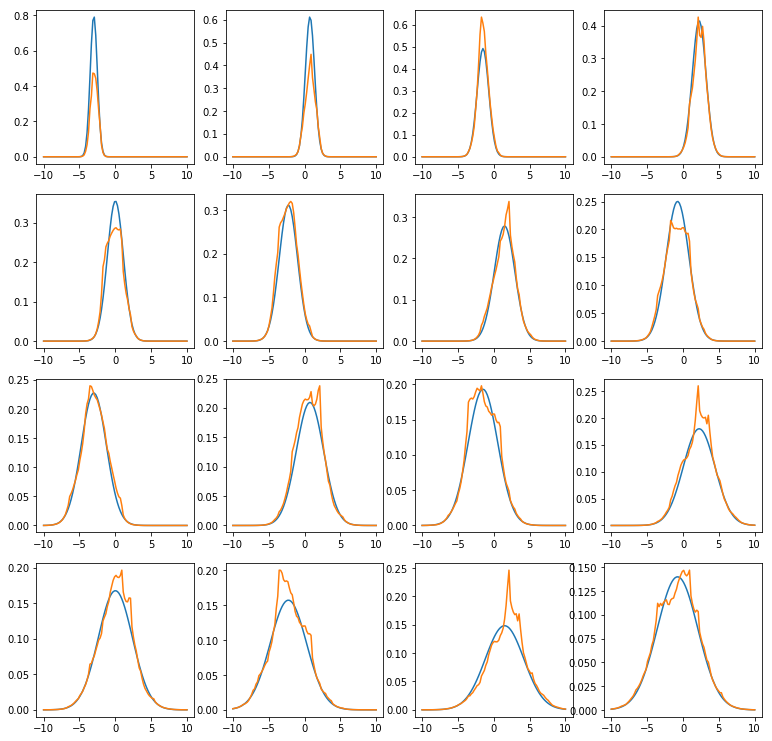

In [138]:
plt.figure(figsize=(13, 13))

for i, ix in enumerate(np.linspace(0, len(predictions), 16, dtype=int, endpoint=False)):
    plt.subplot(4, 4, i+1)
    
    plt.plot(np.linspace(-10, 10, N_SAMPLES), np.exp(x_sampled[ix, :]))
    plt.plot(np.linspace(-10, 10, N_SAMPLES), np.exp(predictions[ix, :]))